In [1]:
import os
import pandas as pd
import csv
import numpy as np
import time

from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_data_path = "/home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output"
annotated_data_path = "/home/yacine/accel/capture24/participants/"

labels_dict_location = "/home/aayush/accelerometer/accprocess/anno-label.csv"
confusion_matrix_location = "/home/aayush/accelerometer/compare_classification/confusion_matrix_output/10_sec/original_features"

test_participants = "101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151"
test_participants = [float(t) for t in test_participants.split(",")]

epoch_time = 1000 # 30 seconds

In [2]:
class logger:
    def __init__(self) -> None:
        timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
        # log = f"{log_path}/Process_data_{timestamp}.log"
        # with open(log, "w") as log_file_save:
        #     log_file_save.write("################################################\n")
        #     log_file_save.write("|Timestamp| + \t + |Func| + \t + |Message|\n")
        # self.log_file = log
    
    def log(self, func, message) -> None:
        # with open(self.log_file, "a") as log_file_save:
        #     timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
        #     log_message = timestamp + "\t" + func + "\t" + message
        #     log_file_save.write(log_message + "\n")

        timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
        log_message = timestamp + "\t" + func + "\t" + message
        print(log_message)

logging = logger()

In [3]:
def get_files(data_path, predicted_files=False, annotated_files=False) -> None:
    total_csv_zipped = []
    for path, dirnames, filenames in os.walk(data_path):
        logging.log("get_files", f"Looking for data files in {path}.")
        for file in filenames:
            if file.endswith(".csv.gz") and predicted_files:
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                # logging.log("get_files", f"Found FILE:{file} in PATH:{path}.")
                
            if file.endswith(".csv") and annotated_files and file[0]!='c': #ignore the capture24 file
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                # logging.log("get_files", f"Found FILE:{file} in PATH:{path}.")
    logging.log("get_files", "#################################################################################")
    logging.log("get_files", f"######### Total files in the data path: {len(total_csv_zipped)} #########")
    logging.log("get_files", "#################################################################################")
    return sorted(total_csv_zipped)

In [4]:
def create_labels_dict():
    logging.log("create_labels_dict", "Created labels dict for mapping.")
    labels_dict = {}
    with open(labels_dict_location, "r") as annotation_dict:
        reader = csv.DictReader(annotation_dict)
        for row in reader:
            if labels_dict.get(row['annotation']) is None:
                labels_dict[row['annotation']] = [row['label:Walmsley2020']]
            else:
                labels_dict[row['annotation']].append(row['label:Walmsley2020'])
    return labels_dict


def parse_datetime(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object


def parse_datetime_df_time(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    clean_datetime_str = clean_datetime_str.split('+')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object

In [5]:
def create_confusion_matrix(actual_labels_cleaned, df_cleaned_filtered):
    assert len(actual_labels_cleaned) == len(df_cleaned_filtered), "DataFrames must be of the same length"

    true_labels = actual_labels_cleaned['annotation']
    predicted_labels = df_cleaned_filtered['activity_predicted']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=['light', 'moderate-vigorous', 'sedentary', 'sleep'])
    
    # logging.log("create_confusion_matrix", "Created confusion matrix.")
    return cm


def display_confusion_matrix(cm, normalize=True):
    # logging.log("display_confusion_matrix", "Display confusion matrix.")
    import matplotlib.pyplot as plt
    
    if normalize:
    # Normalize by true values
        cm = cm.astype(float)
        row_sums = cm.sum(axis=1)

        # Avoid division by zero; replace zeros with ones (or a very small number) in the denominator
        row_sums[row_sums == 0] = 1

        # Normalize each row
        cm = cm / row_sums[:, np.newaxis]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['light', 'mod-vigorous', 'sedentary', 'sleep'])
    disp.plot(cmap='Blues')
    if normalize:
        plt.savefig(os.path.join(confusion_matrix_location, datetime.now().strftime("%m-%d-%Y-%H-%M-%S") + "normalized.png"))
    else:
        plt.savefig(os.path.join(confusion_matrix_location, datetime.now().strftime("%m-%d-%Y-%H-%M-%S") + ".png"))


In [6]:
predicted_data_files = get_files(data_path=predicted_data_path, predicted_files=True)
annotated_data_files = get_files(data_path=annotated_data_path, annotated_files=True)
assert len(predicted_data_files) == len(annotated_data_files), "Number of predicted and annotated data files should be the same."

labels_dict = create_labels_dict()

labels = ["light", "moderate-vigorous", "sedentary", "sleep"]
combined_cm = np.zeros((len(labels), len(labels)), dtype=float)

06-27-2024-13-08-03	get_files	Looking for data files in /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output.
06-27-2024-13-08-03	get_files	#################################################################################
06-27-2024-13-08-03	get_files	######### Total files in the data path: 151 #########
06-27-2024-13-08-03	get_files	#################################################################################
06-27-2024-13-08-03	get_files	Looking for data files in /home/yacine/accel/capture24/participants/.
06-27-2024-13-08-03	get_files	#################################################################################
06-27-2024-13-08-03	get_files	######### Total files in the data path: 151 #########
06-27-2024-13-08-03	get_files	#################################################################################
06-27-2024-13-08-03	create_labels_dict	Created labels dict for mapping.


In [7]:
def decode_activities(data_file):
    # logging.log("decode_activities", f"Decode the activities from file: {data_file}.")
    df = pd.read_csv(data_file)
    
    # retrieve only the activities headers
    activities = df[df.columns.values.tolist()[2:6]]
    
    # whichever activity is depicted by 1, use it as the predicted activity
    out = activities[activities==1].idxmax(axis=1)
    df["activity_predicted"] = out
    
    # logging.log("decode_activities", f"Dropped 'nan' activity_predicted from file: {data_file}.")
    df_cleaned = df.dropna(subset=["activity_predicted"])
    return df_cleaned, df
    
    
def process_annotated_data(annotated_data_file):
    # logging.log("process_annotated_data", f"Process annotated data file: {annotated_data_file}.")
    
    annotated_data = pd.read_csv(annotated_data_file)
    # Take the timestamp after every thirty seconds
    actual_labels = annotated_data[["annotation", "time"]][0::epoch_time]
    
    # Convert to datetime object
    actual_time = actual_labels["time"].apply(parse_datetime)
    actual_labels["time"] = actual_time
    
    return actual_labels
    


def filtering_data(df_cleaned, actual_labels, labels_dict):
    
    # Convert to datetime object
    df_cleaned_time = df_cleaned['time'].apply(parse_datetime_df_time)
    df_cleaned['time_cleaned'] = df_cleaned_time
    
    # drop all 'nan' rows from actual labels
    before_dropped_actual_labels = len(actual_labels)
    actual_labels = actual_labels.dropna(subset=['annotation'])
    after_dropped_actual_labels = len(actual_labels)
    count_dropped_actual_labels_na = before_dropped_actual_labels - after_dropped_actual_labels

    before_timestamp_actual_labels = len(actual_labels)
    # Filter out all those timestamps which do not exist in df_cleaned_time
    actual_labels = actual_labels[actual_labels["time"].isin(df_cleaned_time)]
    after_timestamp_actual_labels = len(actual_labels)
    count_timestamp_actual_labels = before_timestamp_actual_labels - after_timestamp_actual_labels

    # Filter out all those timestamps which do not exist in actual_labels
    before_timestamp_predicted = len(df_cleaned)
    df_cleaned_filtered = df_cleaned[df_cleaned['time_cleaned'].isin(actual_labels["time"])]
    after_timestamp_predicted = len(df_cleaned_filtered)
    count_timestamp_predicted = before_timestamp_predicted - after_timestamp_predicted
    
    # Remove all duplicated timestamps from df_cleaned_filtered
    before_predicted_dedup = len(df_cleaned_filtered)
    df_cleaned_filtered_dedup = df_cleaned_filtered[~df_cleaned_filtered['time_cleaned'].duplicated(keep='first')]
    after_predicted_dedup = len(df_cleaned_filtered_dedup)
    count_dropped_predicted_dedup = before_predicted_dedup - after_predicted_dedup
    
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    flat_dict = {k: v[0] for k, v in labels_dict.items()}
    
    actual_labels['annotation'].replace(flat_dict, inplace=True)
    
    return actual_labels, df_cleaned_filtered_dedup, count_dropped_actual_labels_na, count_dropped_predicted_dedup,  count_timestamp_actual_labels, count_timestamp_predicted

In [8]:
df_cleaned_all = []
df_original_all = []

actual_labels_all = []
actual_labels_cleaned_all = []


predicted_items_na_total = 0
count_dropped_actual_labels_na_total = 0
count_dropped_predicted_dedup_total = 0
count_timestamp_actual_labels_total = 0
count_timestamp_predicted_total = 0


# We only want to consider testParticipants: 101 to 151.
for predicted_file, annotated_file in zip(predicted_data_files[0:100], annotated_data_files[0:100]):
    logging.log("main", f"Processing predicted_file: {predicted_file} and annotated_file:{annotated_file}")

    # In this step we drop the activities which are NaN from the predicted data file
    df_cleaned, df_original = decode_activities(predicted_file)

    predicted_items_na_total += len(df_original) - len(df_cleaned)

    # We process the strings to timestamps for annotated file
    actual_labels = process_annotated_data(annotated_file)

    # In this step:
    # We convert the strings to timestamps for cleaned predicted data file
    # drop all 'nan' rows from actual labels
    # Filter out all those timestamps which do not exist in df_cleaned_time
    # Filter out all those timestamps which do not exist in actual_labels
    # Remove all duplicated timestamps from df_cleaned_filtered
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    actual_labels_cleaned, df_cleaned_filtered, count_dropped_actual_labels_na, count_dropped_predicted_dedup,  count_timestamp_actual_labels, count_timestamp_predicted = filtering_data(df_cleaned, actual_labels, labels_dict)

    # logging.log("main", f"Number of dropped items from predicted df due to NA values: {len(df_original) - len(df_cleaned)}")
    # logging.log("main", f"Number of dropped items from actual_label df due to NA values: {count_dropped_actual_labels_na}")
    # logging.log("main", f"Number of dropped items from predicted df due to duplicate timestamps: {count_dropped_predicted_dedup}")
    # logging.log("main", f"Number of dropped items from actual_label df due to timestamp mismatch with predicted df: {count_timestamp_actual_labels}")
    # logging.log("main", f"Number of dropped items from predicted df due to timestamp mismatch with actual_label df: {count_timestamp_predicted}")
    

    count_dropped_actual_labels_na_total += count_dropped_actual_labels_na
    count_dropped_predicted_dedup_total += count_dropped_predicted_dedup
    count_timestamp_actual_labels_total += count_timestamp_actual_labels
    count_timestamp_predicted_total += count_timestamp_predicted
    
    
    cm = create_confusion_matrix(actual_labels_cleaned, df_cleaned_filtered)
    combined_cm += cm

    df_cleaned_all.append(df_cleaned_filtered)
    df_original_all.append(df_original)
    
    actual_labels_all.append(actual_labels)
    actual_labels_cleaned_all.append(actual_labels_cleaned)
    
print("##############DONE#############")

06-27-2024-13-08-04	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P001-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P001.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-08-19	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P002-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P002.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-08-31	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P003-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P003.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-08-46	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P004-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P004.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-08-57	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P005-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P005.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-09-11	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P006-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P006.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-09-27	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P007-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P007.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-09-41	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P008-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P008.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-09-55	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P009-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P009.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-10-05	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P010-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P010.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-10-19	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P011-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P011.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-10-32	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P012-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P012.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-10-45	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P013-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P013.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-10-57	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P014-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P014.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-11-11	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P015-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P015.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-11-24	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P016-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P016.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-11-37	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P017-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P017.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-11-52	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P018-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P018.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-12-03	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P019-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P019.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-12-17	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P020-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P020.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-12-29	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P021-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P021.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-12-42	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P022-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P022.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-12-57	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P023-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P023.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-13-10	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P024-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P024.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-13-25	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P025-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P025.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-13-38	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P026-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P026.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-13-50	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P027-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P027.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-14-04	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P028-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P028.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-14-16	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P029-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P029.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-14-30	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P030-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P030.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-14-45	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P031-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P031.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-14-58	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P032-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P032.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-15-10	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P033-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P033.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-15-24	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P034-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P034.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-15-37	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P035-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P035.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-15-50	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P036-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P036.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-16-02	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P037-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P037.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-16-14	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P038-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P038.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-16-28	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P039-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P039.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-16-41	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P040-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P040.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-16-53	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P041-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P041.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-17-07	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P042-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P042.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-17-19	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P043-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P043.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-17-33	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P044-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P044.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-17-45	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P045-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P045.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-17-57	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P046-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P046.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-18-10	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P047-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P047.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-18-21	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P048-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P048.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-18-34	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P049-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P049.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-18-47	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P050-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P050.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-19-00	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P051-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P051.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-19-12	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P052-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P052.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-19-23	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P053-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P053.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-19-37	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P054-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P054.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-19-52	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P055-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P055.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-20-06	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P056-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P056.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-20-19	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P057-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P057.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-20-33	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P058-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P058.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-20-46	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P059-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P059.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-20-59	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P060-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P060.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-21-11	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P061-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P061.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-21-23	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P062-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P062.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-21-36	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P063-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P063.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-21-48	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P064-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P064.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-22-02	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P065-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P065.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-22-15	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P066-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P066.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-22-29	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P067-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P067.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-22-42	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P068-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P068.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-22-54	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P069-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P069.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-23-07	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P070-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P070.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-23-20	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P071-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P071.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-23-32	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P072-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P072.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-23-45	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P073-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P073.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-23-59	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P074-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P074.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-24-12	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P075-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P075.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-24-24	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P076-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P076.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-24-38	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P077-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P077.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-24-50	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P078-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P078.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-25-04	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P079-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P079.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-25-15	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P080-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P080.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-25-32	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P081-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P081.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-25-39	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P082-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P082.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-25-51	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P083-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P083.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-26-04	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P084-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P084.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-26-18	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P085-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P085.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-26-31	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P086-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P086.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-26-44	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P087-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P087.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-26-55	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P088-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P088.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-27-08	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P089-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P089.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-27-21	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P090-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P090.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-27-34	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P091-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P091.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-27-47	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P092-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P092.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-28-00	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P093-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P093.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-28-14	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P094-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P094.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-28-21	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P095-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P095.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-28-33	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P096-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P096.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-28-46	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P097-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P097.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_1379260/2825748892.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


06-27-2024-13-28-59	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P098-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P098.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-29-14	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P099-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P099.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


06-27-2024-13-29-27	main	Processing predicted_file: /home/aayush/accelerometer/compare_classification/accProcess_output/10_sec/original_features/predicted_output/P100-timeSeries.csv.gz and annotated_file:/home/yacine/accel/capture24/participants/P100.csv


/tmp/ipykernel_1379260/2143372201.py:25: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


##############DONE#############


In [9]:
df_cleaned_all_pd = pd.concat(df_cleaned_all, ignore_index=True, axis=0)
df_original_all_pd = pd.concat(df_original_all, ignore_index=True, axis=0)

actual_labels_all_pd = pd.concat(actual_labels_all, ignore_index=True, axis=0)
actual_labels_cleaned_all_pd = pd.concat(actual_labels_cleaned_all, ignore_index=True, axis=0)

In [10]:
print(f"Number of dropped items from predicted df due to NA values: {predicted_items_na_total}")
print(f"Number of dropped items from actual_label df due to NA values: {count_dropped_actual_labels_na_total}")
print(f"Number of dropped items from predicted df due to duplicate timestamps: {count_dropped_predicted_dedup_total}")
print(f"Number of dropped items from actual_label df due to timestamp mismatch with predicted df: {count_timestamp_actual_labels_total}")
print(f"Number of dropped items from predicted df due to timestamp mismatch with actual_label df: {count_timestamp_predicted_total}")

Number of dropped items from predicted df due to NA values: 9512
Number of dropped items from actual_label df due to NA values: 312947
Number of dropped items from predicted df due to duplicate timestamps: 360
Number of dropped items from actual_label df due to timestamp mismatch with predicted df: 29586
Number of dropped items from predicted df due to timestamp mismatch with actual_label df: 337658


In [11]:
# print(df_cleaned_all_pd)
# print(df_original_all_pd)

# print(actual_labels_all_pd)
# print(actual_labels_cleaned_all_pd)

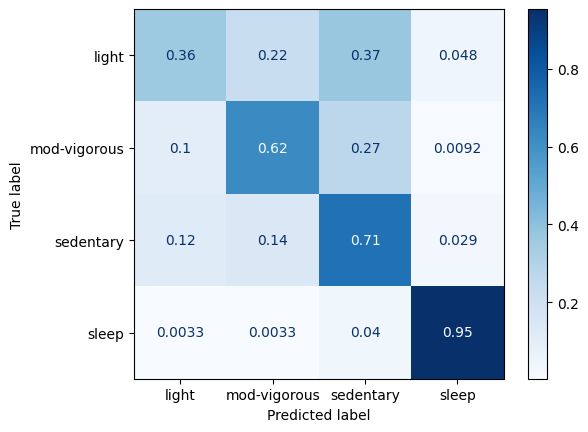

In [12]:
display_confusion_matrix(combined_cm, normalize=True)

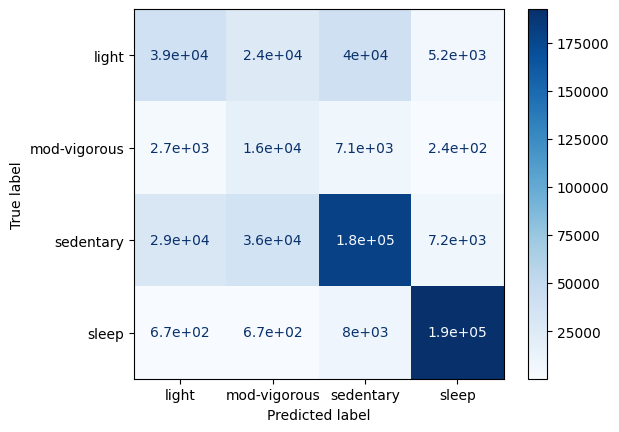

In [13]:
display_confusion_matrix(combined_cm, normalize=False)